# Ocean Colour Modelling Framework (OCMF)
This jupyter program is used to illustrate the Ocean Colour Modelling Framework (OCMF) proposed in Sun, Brewin et al. (under review) for estimating remote sensing reflectance (Rrs) from chlorophyll-a concentration (Chl-a) and sea surface temperature (SST).

In [2]:
# loading packages
import pandas as pd
import numpy as np
import numpy.matlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import copy
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [3]:
# loading python script for calculating backscattering of water (Zhang and Hu, 2009, https://doi.org/10.1364/OE.17.001671; Zhang et al., 2009, https://doi.org/10.1364/OE.17.005698)
import betasw124_ZHH2009

In [4]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Set up a dataset with Chl-a, SST, and salinity as inputs
Where Chl-a ranges from 0.01 to 10 ($\rm mg~m^{-3}$), SST ranges from -1.8 to 35 ($^{\circ}$C), and salinity is fixed at 35 ppt.

In [5]:
num_chla = 50
num_sst = 30

chla = np.logspace(-2, 1, num=num_chla) 
sst = np.linspace(-1.8, 33, num=num_sst)
salinity = 35

data = pd.DataFrame(list(itertools.product(chla, sst)), columns=['TChl_a','SST'])
data.insert(2, 'Salinity', salinity)

### The OCMF explicitly incorperates the ecological model (Sun et al., 2023)
Here, SST-dependent models (i.e., 16- and 17-parameter models) are used in the OCMF that partition total Chl-a into size fractions. 

In [6]:
# calculate PSCs from Chl-a and SST
data_pscs = copy.deepcopy(data)

# 16-parameter Model
g1,g2,g3,g4 = -0.56,-3.79,1.92,-0.14
h1,h2,h3,h4 = -0.28,1.13,5.03,0.89
j1,j2,j3,j4 = 0.39,0.33,8.02,0.55 
k1,k2,k3,k4 = 0.65,0.22,12.79,0.09 

model_b_cnp = 1 - (g1/(1 + np.exp(-g2*(data_pscs.SST - g3))) + g4)
model_b_cp = 1 - (h1/(1 + np.exp(-h2*(data_pscs.SST - h3))) + h4)
model_b_dnp = j1/(1 + np.exp(-j2*(data_pscs.SST - j3))) + j4
model_b_dp = k1/(1 + np.exp(-k2*(data_pscs.SST - k3))) + k4

data_pscs['Cnp_16'] = model_b_cnp*(1-np.exp(-model_b_dnp/model_b_cnp*data_pscs.TChl_a))
data_pscs['Cp_16'] = model_b_cp*(1-np.exp(-model_b_dp/model_b_cp*data_pscs.TChl_a))
data_pscs['Cn_16'] = data_pscs['Cnp_16']-data_pscs['Cp_16']
data_pscs['Cm_16'] = data_pscs.TChl_a-data_pscs['Cnp_16']

data_pscs['Fp_16'] = data_pscs['Cp_16']/data_pscs.TChl_a
data_pscs['Fn_16'] = data_pscs['Cn_16']/data_pscs.TChl_a
data_pscs['Fm_16'] = data_pscs['Cm_16']/data_pscs.TChl_a
data_pscs['Fnp_16'] = data_pscs['Cnp_16']/data_pscs.TChl_a

#17-parameter Model
g1,g2,g3 = 0.003,-0.08,1.61 #cnp
h1,h2,h3,h4,h5,h6 = 0.52,12.71,8.95,0.30,27.52,4.61 #cp
j1,j2,j3,j4 =  0.39,0.33,8.02,0.55 #dnp
k1,k2,k3,k4 =  0.65,0.22,12.79,0.09 #dp

model_c_cnp = g1*data_pscs.SST*data_pscs.SST + g2*data_pscs.SST + g3
model_c_cp = h1*np.exp(-((data_pscs.SST-h2)/h3)**2) + h4*np.exp(-((data_pscs.SST-h5)/h6)**2)
model_c_dnp = j1/(1 + np.exp(-j2*(data_pscs.SST - j3)))+ j4
model_c_dp = k1/(1 + np.exp(-k2*(data_pscs.SST - k3)))+k4

data_pscs['Cnp_17'] = model_c_cnp*(1-np.exp(-model_c_dnp/model_c_cnp*data_pscs.TChl_a))
data_pscs['Cp_17'] = model_c_cp*(1-np.exp(-model_c_dp/model_c_cp*data_pscs.TChl_a))
data_pscs['Cn_17'] = data_pscs['Cnp_17']-data_pscs['Cp_17']
data_pscs['Cm_17'] = data_pscs.TChl_a-data_pscs['Cnp_17']

data_pscs['Fp_17'] = data_pscs['Cp_17']/data_pscs.TChl_a
data_pscs['Fn_17'] = data_pscs['Cn_17']/data_pscs.TChl_a
data_pscs['Fm_17'] = data_pscs['Cm_17']/data_pscs.TChl_a
data_pscs['Fnp_17'] = data_pscs['Cnp_17']/data_pscs.TChl_a

### Absorption
$a(\lambda)~=~a_w(\lambda)~+~a_{ph}(\lambda)~+~a_{d}(\lambda)~+~a_{g}(\lambda)$

In [7]:
# absorption of water-aw (Lee et al., 2015, https://doi.org/10.1364/AO.54.000546)
aw = pd.read_excel('input.xlsx')['aw']
model_aw = pd.DataFrame(data=aw.values.reshape(-1, 1).repeat(len(data), axis=1)).T
model_aw.columns = [i for i in map(str,np.arange(700,399,-1))] 
data_aw = copy.deepcopy(data)
data_aw = pd.concat([data_aw, model_aw], axis=1)

In [8]:
# absorption of phytoplankton-aph
specific_aph_16 = pd.read_excel('input.xlsx', sheet_name='aph_16').iloc[:,1:]
specific_aph_17 = pd.read_excel('input.xlsx', sheet_name='aph_17').iloc[:,1:]

model_aph_16 = np.dot(specific_aph_16.loc[:,'Pico':'Micro'], data_pscs[['Cp_16','Cn_16','Cm_16']].T).T
model_aph_17 = np.dot(specific_aph_17.loc[:,'Pico':'Micro'], data_pscs[['Cp_17','Cn_17','Cm_17']].T).T

model_aph_16 = pd.DataFrame(model_aph_16, columns=[i for i in map(str,np.arange(700,399,-1))])  
model_aph_17 = pd.DataFrame(model_aph_17, columns=[i for i in map(str,np.arange(700,399,-1))])  

data_aph_16 = copy.deepcopy(data)
data_aph_16 = pd.concat([data_aph_16, model_aph_16], axis=1)

data_aph_17 = copy.deepcopy(data)
data_aph_17 = pd.concat([data_aph_17, model_aph_17], axis=1)

In [9]:
# absorption of NAP-ad
specific_ad_16 = pd.read_excel('input.xlsx', sheet_name='ad_16').iloc[:,1:]
specific_ad_17 = pd.read_excel('input.xlsx', sheet_name='ad_17').iloc[:,1:]

model_ad_16 = np.dot(specific_ad_16.loc[:,'Pico':'Micro'], data_pscs[['Cp_16','Cn_16','Cm_16']].T).T + np.matlib.repmat(specific_ad_16['ak'], len(data), 1)
model_ad_17 = np.dot(specific_ad_17.loc[:,'Pico':'Micro'], data_pscs[['Cp_17','Cn_17','Cm_17']].T).T + np.matlib.repmat(specific_ad_17['ak'], len(data), 1)

model_ad_16 = pd.DataFrame(model_ad_16, columns=[i for i in map(str,np.arange(700,399,-1))])  
model_ad_17 = pd.DataFrame(model_ad_17, columns=[i for i in map(str,np.arange(700,399,-1))])  

data_ad_16 = copy.deepcopy(data)
data_ad_16 = pd.concat([data_ad_16, model_ad_16], axis=1)

data_ad_17 = copy.deepcopy(data)
data_ad_17 = pd.concat([data_ad_17, model_ad_17], axis=1)

In [10]:
# absorption of CDOM-ag, with adjustion
specific_ag_16 = pd.read_excel('input.xlsx', sheet_name='ag_16').iloc[:,1:]
specific_ag_17 = pd.read_excel('input.xlsx', sheet_name='ag_17').iloc[:,1:]

ratio_16 = pd.read_excel('input.xlsx', sheet_name='ag_fraction_16')
ratio_17 = pd.read_excel('input.xlsx', sheet_name='ag_fraction_17')

ag_select_16 = specific_ag_16*ratio_16['fraction'][0]
ag_select_17 = specific_ag_17*ratio_17['fraction'][0]

model_ag_16 = np.dot(ag_select_16.loc[:,'Pico':'Micro'], data_pscs[['Cp_16','Cn_16','Cm_16']].T).T
model_ag_17 = np.dot(ag_select_17.loc[:,'Pico':'Micro'], data_pscs[['Cp_17','Cn_17','Cm_17']].T).T

model_ag_16 = pd.DataFrame(model_ag_16, columns=[i for i in map(str,np.arange(700,399,-1))])  
model_ag_17 = pd.DataFrame(model_ag_17, columns=[i for i in map(str,np.arange(700,399,-1))])  

data_ag_16 = copy.deepcopy(data)
data_ag_16 = pd.concat([data_ag_16, model_ag_16], axis=1)

data_ag_17 = copy.deepcopy(data)
data_ag_17 = pd.concat([data_ag_17, model_ag_17], axis=1)

In [11]:
# total absorption
total_a_16 = data_aw.loc[:,'700':'400'] + data_aph_16.loc[:,'700':'400'] + data_ad_16.loc[:,'700':'400'] + data_ag_16.loc[:,'700':'400']
total_a_17 = data_aw.loc[:,'700':'400'] + data_aph_17.loc[:,'700':'400'] + data_ad_17.loc[:,'700':'400'] + data_ag_17.loc[:,'700':'400']

### Backscattering
$b_b(\lambda)~=~b_{bw}(\lambda)~+~b_{bp}(\lambda)$

In [12]:
# backscattering of water-bbw (Zhang and Hu, 2009, https://doi.org/10.1364/OE.17.001671; Zhang et al., 2009, https://doi.org/10.1364/OE.17.005698)
bsw = betasw124_ZHH2009.betasw124_ZHH2009(np.arange(700,399,-1), data.Salinity, data.SST)[1]
bbw = bsw/2
bbw = pd.DataFrame(bbw, columns=[i for i in map(str,np.arange(700,399,-1))])    

data_bbw = copy.deepcopy(data)
data_bbw = pd.concat([data_bbw, bbw], axis=1)

In [13]:
# backscattering of particles-bbp
specific_bbp_16 = pd.read_excel('input.xlsx', sheet_name='bbp_16').iloc[:,1:]
specific_bbp_17 = pd.read_excel('input.xlsx', sheet_name='bbp_17').iloc[:,1:]

model_bbp_16 = np.dot(specific_bbp_16.loc[:,'Pico':'Micro'], data_pscs[['Cp_16','Cn_16','Cm_16']].T).T + np.matlib.repmat(specific_bbp_16['bbk'], len(data), 1)
model_bbp_17 = np.dot(specific_bbp_17.loc[:,'Pico':'Micro'], data_pscs[['Cp_17','Cn_17','Cm_17']].T).T + np.matlib.repmat(specific_bbp_17['bbk'], len(data), 1)

model_bbp_16 = pd.DataFrame(model_bbp_16, columns=[i for i in map(str,np.arange(700,399,-1))])  
model_bbp_17 = pd.DataFrame(model_bbp_17, columns=[i for i in map(str,np.arange(700,399,-1))])  

data_bbp_16 = copy.deepcopy(data)
data_bbp_16 = pd.concat([data_bbp_16, model_bbp_16], axis=1)

data_bbp_17 = copy.deepcopy(data)
data_bbp_17 = pd.concat([data_bbp_17, model_bbp_17], axis=1)

In [14]:
# total backscattering
total_bb_16 = data_bbw.loc[:,'700':'400'] + data_bbp_16.loc[:,'700':'400']
total_bb_17 = data_bbw.loc[:,'700':'400'] + data_bbp_17.loc[:,'700':'400']

### Remote sensing of reflectance (Lee et al., 2013, https://doi.org/10.1002/jgrc.20308)
$R_{rs}(\lambda, \Omega)~=~(G^w_0(\Omega)~+~G^w_1(\Omega)~\frac{b_{bw}(\lambda)}{\kappa(\lambda)})~\frac{b_{bw}(\lambda)}{\kappa(\lambda)}~+~(G^p_0(\Omega)~+~G^p_1(\Omega)~\frac{b_{bp}(\lambda)}{\kappa(\lambda)})~\frac{b_{bp}(\lambda)}{\kappa(\lambda)}$

In [15]:
# calculate Rrs
k_16 = total_a_16 + total_bb_16
Rrs_16 = (0.0604+0.0406*(data_bbw.loc[:,'700':'400']/k_16))*(data_bbw.loc[:,'700':'400']/k_16)+(0.0402+0.1310*(data_bbp_16.loc[:,'700':'400']/k_16))*(data_bbp_16.loc[:,'700':'400']/k_16)

k_17 = total_a_17 + total_bb_17
Rrs_17 = (0.0604+0.0406*(data_bbw.loc[:,'700':'400']/k_17))*(data_bbw.loc[:,'700':'400']/k_17)+(0.0402+0.1310*(data_bbp_17.loc[:,'700':'400']/k_17))*(data_bbp_17.loc[:,'700':'400']/k_17)

Rrs_16.columns = ['Rrs_'+ i for i in map(str,np.arange(700,399,-1))]
data_Rrs_16 = pd.concat([data,Rrs_16], axis=1)

Rrs_17.columns = ['Rrs_'+ i for i in map(str,np.arange(700,399,-1))]
data_Rrs_17 = pd.concat([data,Rrs_17], axis=1)

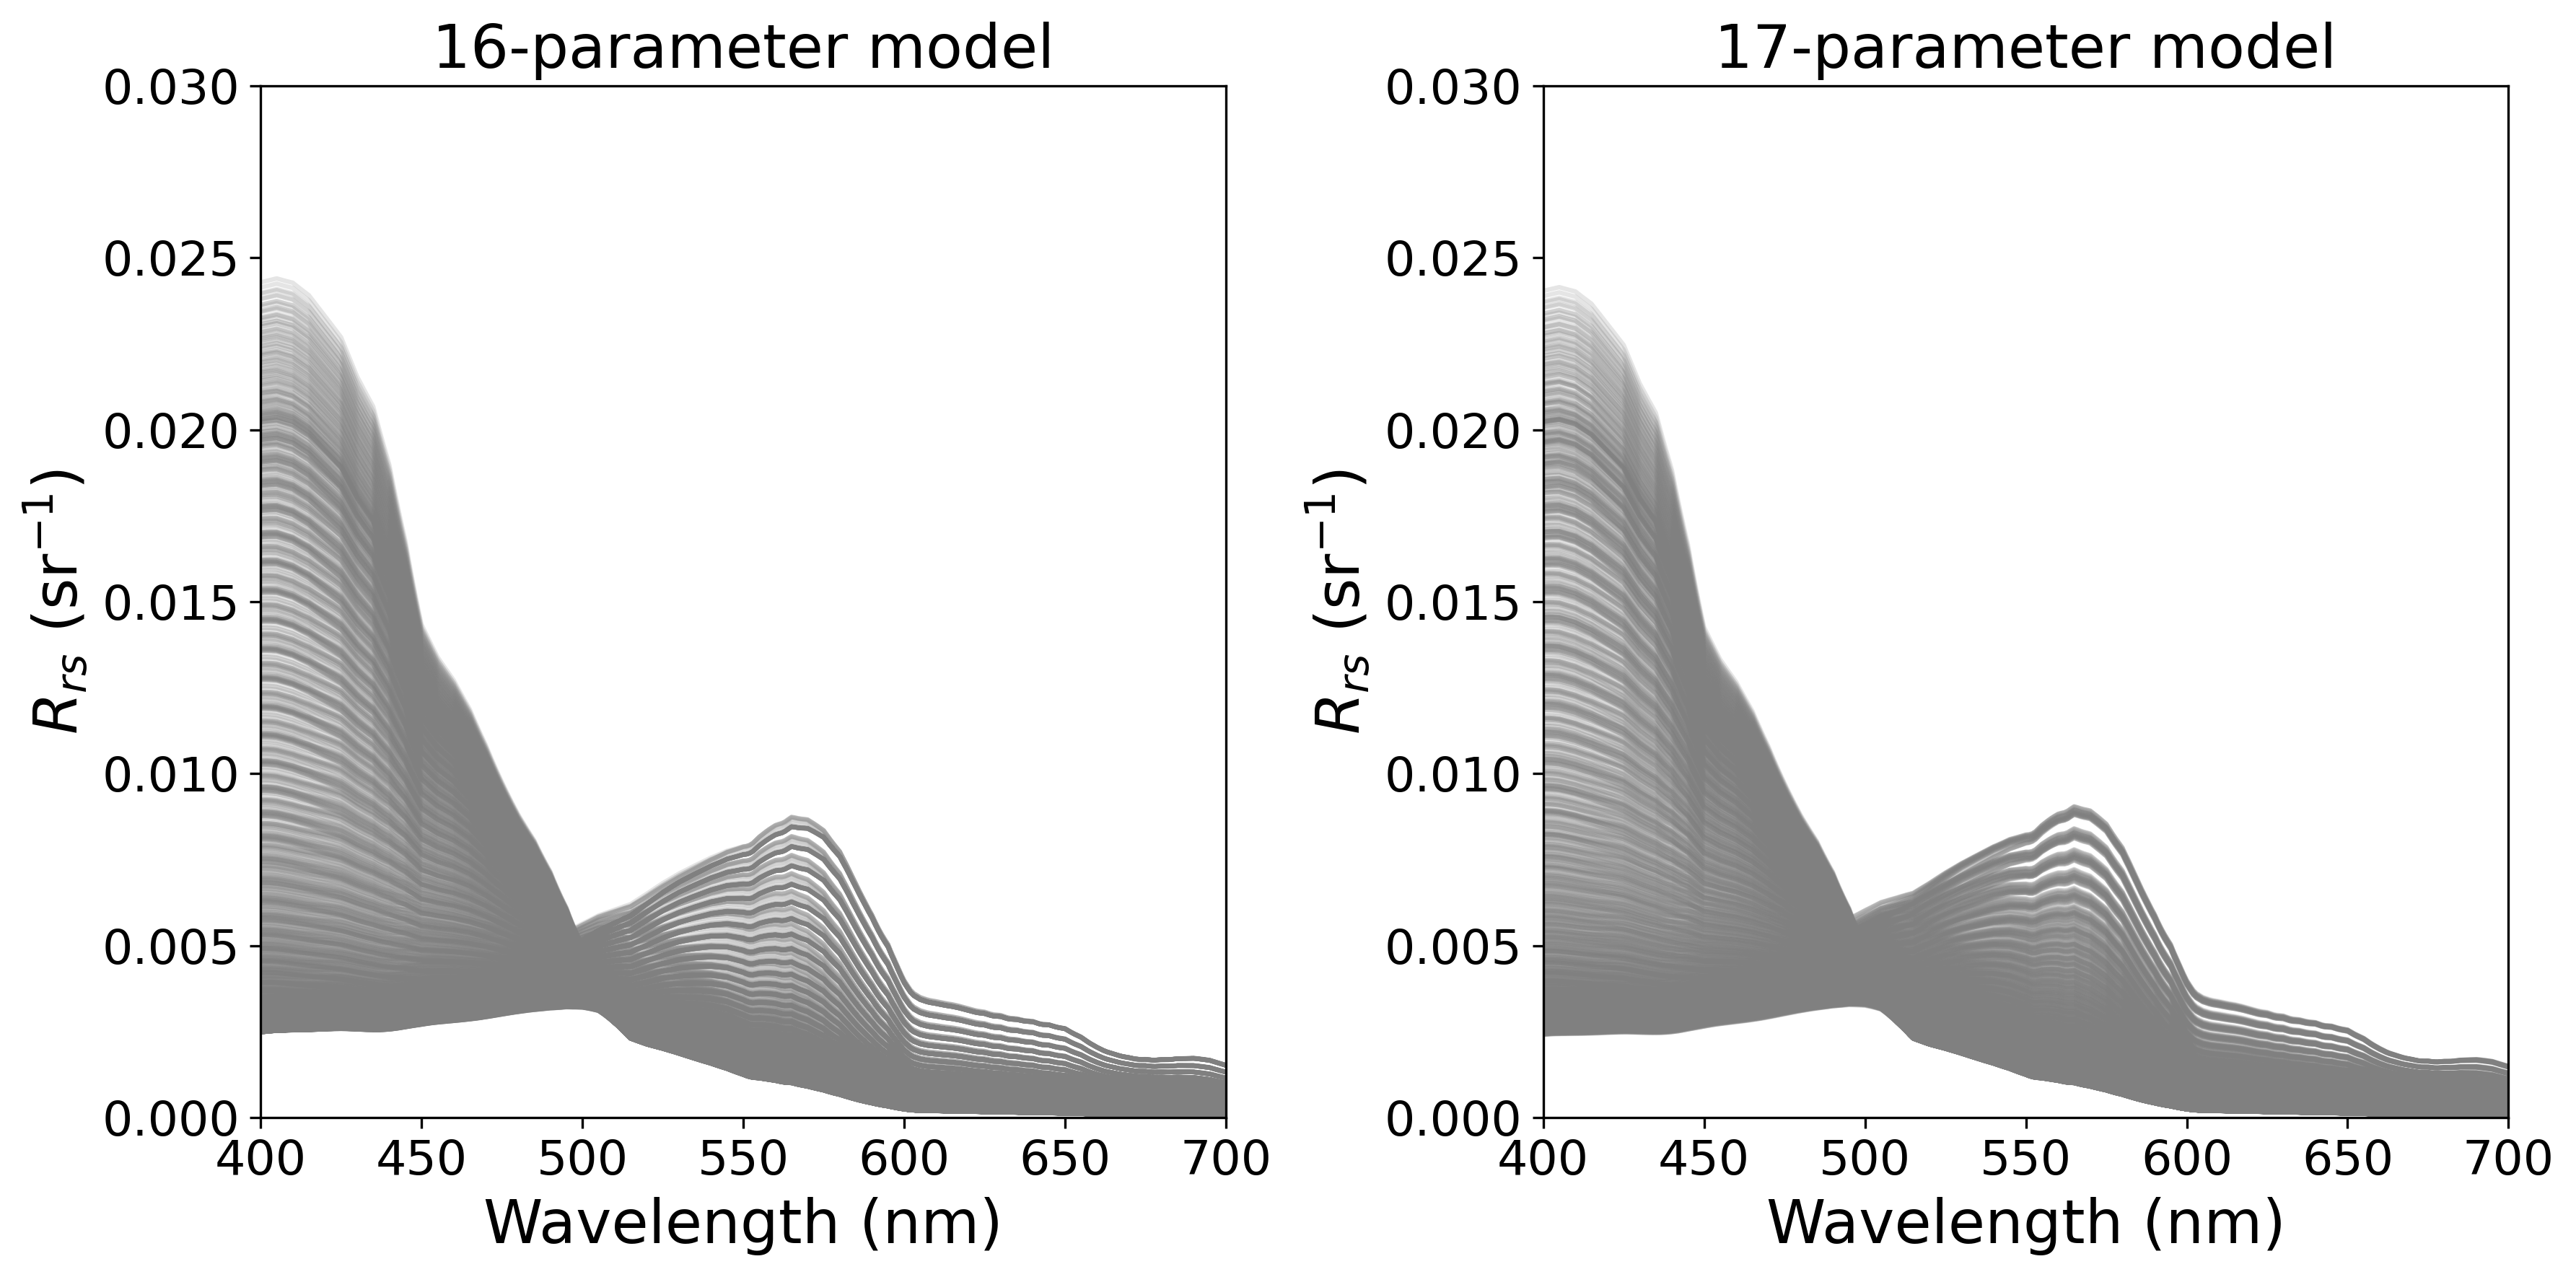

In [16]:
# plot Rrs
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,6),dpi=300)

for i in range(0, len(data_Rrs_16)):
    axes[0].plot(np.arange(700, 399, -1), data_Rrs_16.loc[i,'Rrs_700':'Rrs_400'], c='grey', alpha=0.2)    
axes[0].set_xlabel('Wavelength'+' (nm)', fontsize = 20)
axes[0].set_ylabel(r'$R_{rs}$'+' ($\mathregular{sr^{-1}}$)', fontsize = 20)
axes[0].set_xlim([400,700])
axes[0].set_ylim([0, 0.03])
axes[0].xaxis.set_tick_params(labelsize=16)
axes[0].yaxis.set_tick_params(labelsize=16)
axes[0].set_title('16-parameter model', fontsize = 20)

for i in range(0, len(data_Rrs_17)):
    axes[1].plot(np.arange(700, 399, -1), data_Rrs_17.loc[i,'Rrs_700':'Rrs_400'], c='grey', alpha=0.2)    
axes[1].set_xlabel('Wavelength'+' (nm)', fontsize = 20)
axes[1].set_ylabel(r'$R_{rs}$'+' ($\mathregular{sr^{-1}}$)', fontsize = 20)
axes[1].set_xlim([400,700])
axes[1].set_ylim([0, 0.03])
axes[1].xaxis.set_tick_params(labelsize=16)
axes[1].yaxis.set_tick_params(labelsize=16)
axes[1].set_title('17-parameter model', fontsize = 20)

fig.tight_layout()